In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas_datareader import data as web
import seaborn as sb
import sys

sys.path.append("..")

import utils.getStockData as stockData

# APPLE Stock Price Analysis

In [2]:
startDate = '2017-12-01'
endDate = '2022-03-18'

def getStock(name, start, end):
    data = (web.DataReader(name, data_source="yahoo", start=startDate, end=endDate))['Close']
    data = pd.DataFrame(data)
    data = data.sort_values('Date')
    data = data.groupby('Date')['Close'].sum().reset_index()
    data.Date = pd.to_datetime(data.Date, format='%Y%m%d', errors='ignore')
    data = data.set_index('Date')
    data.index = pd.to_datetime(data.index)

    print(data.columns)

    return data

aapl = getStock("AAPL", startDate, endDate)
aapl = aapl[1:]  #start from Dec 2017

aapl

Index(['Close'], dtype='object')


,Close
Date,
2017-12-01,42.762501
2017-12-04,42.450001
2017-12-05,42.410000
2017-12-06,42.252499
2017-12-07,42.330002
...,...
2022-03-14,150.619995
2022-03-15,155.089996
2022-03-16,159.589996


Text(0.5, 1.0, 'AAPL Daily Close Price')

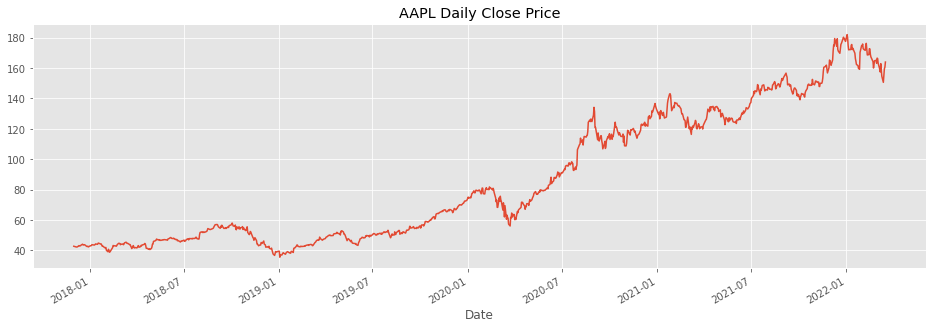

In [3]:
plt.style.use('ggplot')

aapl.plot(legend=False, figsize=(16, 5))
plt.title('AAPL Daily Close Price')

## Rolling Mean and Variance

Rolling window size (m): the number of consecutive observation per rolling window. Longer rolling window sizes tend to yield smoother rolling window estimates than shorter sizes.

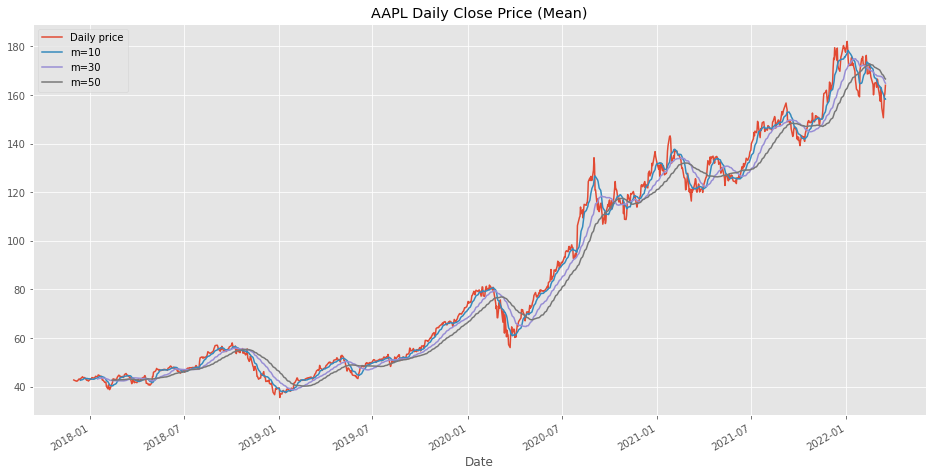

In [4]:
ax = aapl.plot(legend=False, figsize=(16, 8))
ax.set_title('AAPL Daily Close Price (Mean)')

aapl.rolling(window=10).mean().plot(ax=ax)
aapl.rolling(window=30).mean().plot(ax=ax)
aapl.rolling(window=50).mean().plot(ax=ax)
ax.legend(['Daily price', 'm=10', 'm=30', 'm=50'])

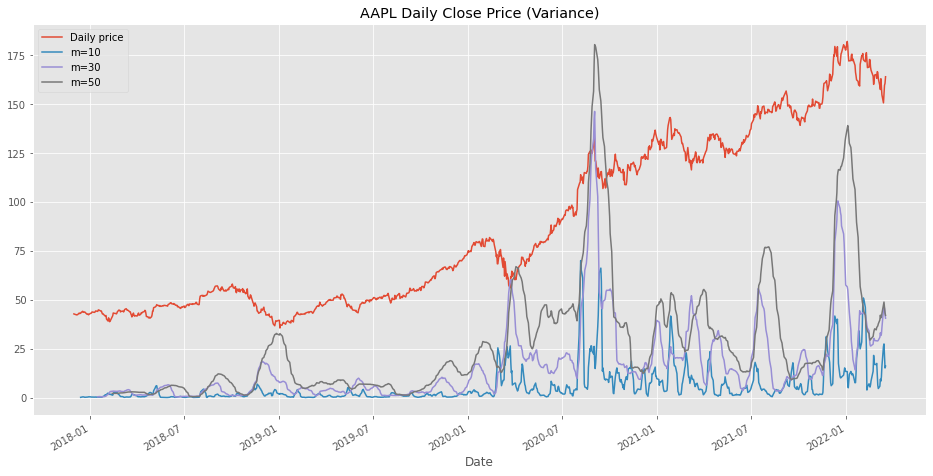

In [5]:
ax = aapl.plot(legend=False, figsize=(16, 8))
ax.set_title('AAPL Daily Close Price (Variance)')

aapl.rolling(window=10).var().plot(ax=ax)
aapl.rolling(window=30).var().plot(ax=ax)
aapl.rolling(window=50).var().plot(ax=ax)
ax.legend(['Daily price', 'm=10', 'm=30', 'm=50'])

## Decomposition

Decompose the AAPL time series to Trend-cycle (Tₜ), Seasonality (Sₜ), Remainder (Rₜ)

The peaks stay constant and do not change their heights -> Additive decomposition (Yₜ = Sₜ + Tₜ + Rₜ)

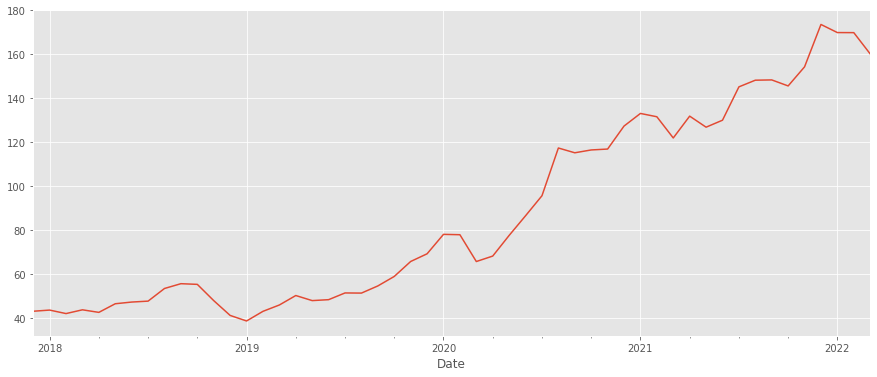

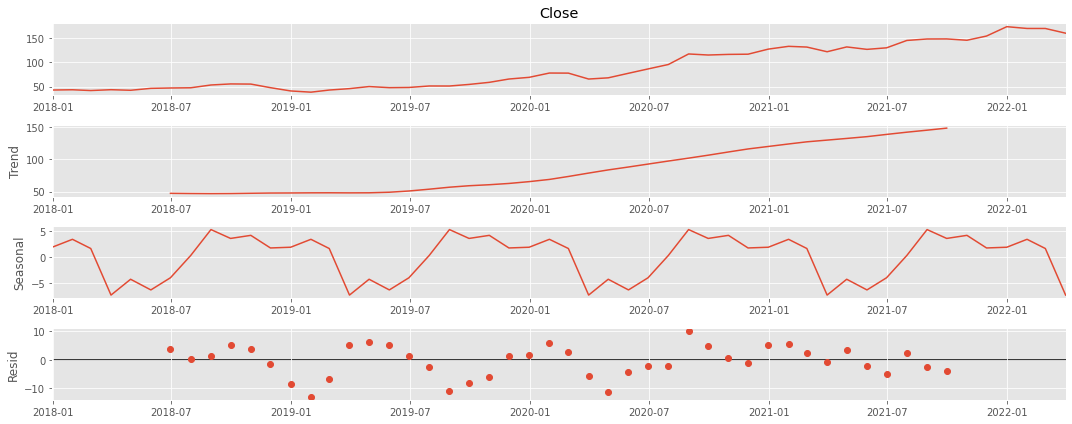

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 15, 6

monthly_mean = aapl.Close.resample('M').mean()

monthly_mean.plot()
plt.show()

aapl_decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = aapl_decomposition.plot()
plt.show()


--> The close price has increasing trend, with clear seasonality, and the residual shows its high variance

--> We may use Seasonal ARIMA for forcasting value

## Augmented Dickey-Fuller (ADF) (Stationary Test)

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(aapl.iloc[:,0].values)
print(f'p value is {result[1]}')

p value is 0.9627327253273565


--> p value is larger than the significance level of 0.05, thus, the time series data is non-stationary.

### --> Need to make the data stationary to forecast, may use differencing

"When both time series variables are non-stationary, they may show strong correlation even through the underlying generation processes have no casual relationships. This strong correlation may be purely caused by the fact that the two time series variables have non-constant mean. This phenomenon is called spurious relationship."

### --> If other stocks are non-stationary like APPLE, there should be more factors to consider when creating portfolio other than just correlation

## Make data stationary

In [8]:
#Differencing
aapl = aapl.diff()
aapl = aapl.dropna()

In [9]:
#Test stationary again
result = adfuller(aapl.iloc[:,0].values)
print(f'p value is {result[1]}')

p value is 2.846268021179777e-10


--> p is now smaller than the significant level of 0.05, so the data is now STATIONARY

--> With first-order differencing, we can use the data to forecase future stock value

## Autocorrelation Function (ACF)

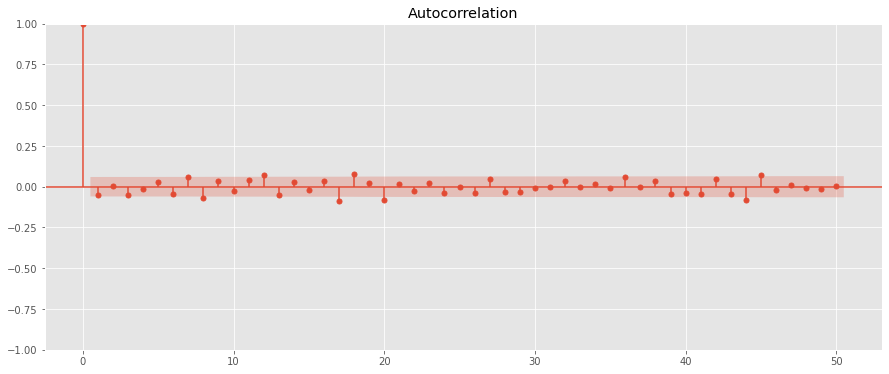

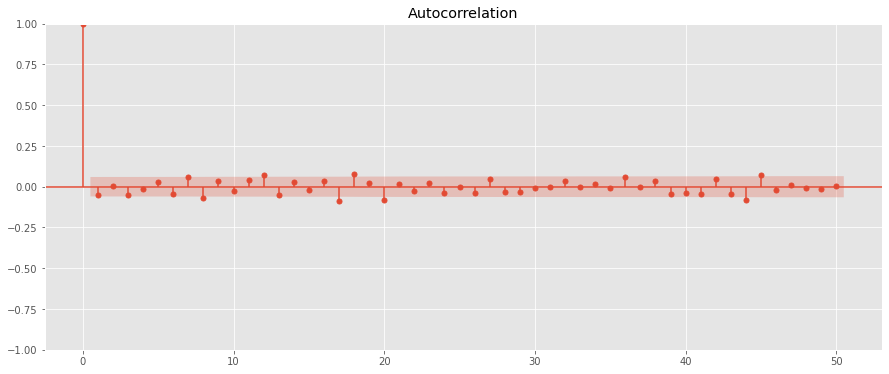

In [10]:
sm.graphics.tsa.plot_acf(aapl, lags=50)

--> The autocorrelation value mostly lie within the red area, so the autocorrelation is not significant

--> We have luckily stationarize the data, and can use the autocorrelation info to choose the right parameter for our ARIMA model

Note: The value at lag 0 will always be 1 and significant since it’s the autocorrelation of a time series with itself corr(Yₜ,Yₜ). It can be seen as a reference point.